In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch import autocast

import nflows
from nflows import flows, transforms, distributions
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

np.random.seed(100)
print(torch.cuda.is_available())

True


In [2]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [3]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        self.data = dataframe
        if rows is not None:
            self.data = self.data.iloc[:rows]
        self.target = self.data[target_variables].values
        self.context = self.data[context_variables].values
        self.weights = self.data[['weight']].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)
            self.weights = torch.tensor(self.weights, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx], self.weights[idx]

In [4]:
input_dir = "./samples"
df = pd.read_parquet(os.path.join(input_dir, "train.parquet"))
df_target = pd.read_parquet(os.path.join(input_dir, "train_target.parquet"))
df_test = pd.read_parquet(os.path.join(input_dir, "test.parquet"))
df_target_test = pd.read_parquet(os.path.join(input_dir, "test_target.parquet"))

In [5]:
"""
from sklearn.preprocessing import StandardScaler

for d in [df, df_target, df_test, df_target_test]:
    for var in ['x', 'y']:
        d[var] = StandardScaler().fit_transform(d[var].values.reshape(-1, 1))

plt.hist(df['x'], bins=100);
"""

"\nfrom sklearn.preprocessing import StandardScaler\n\nfor d in [df, df_target, df_test, df_target_test]:\n    for var in ['x', 'y']:\n        d[var] = StandardScaler().fit_transform(d[var].values.reshape(-1, 1))\n\nplt.hist(df['x'], bins=100);\n"

In [6]:
df['lab'] = 1
df_test['lab'] = 1
df_target['lab'] = 0
df_target_test['lab'] = 0

In [7]:
new_df_train = pd.concat([df, df_target])
new_df_train = new_df_train.reset_index(drop=True)
new_df_train = new_df_train.sample(frac=1).reset_index(drop=True)
new_df_test = pd.concat([df_test, df_target_test])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.sample(frac=1).reset_index(drop=True)

In [8]:
context_vars = ['a', 'b', 'lab']
input_vars = ['x', 'y']
rows = 300000
rows_test = 100000
batch_size = 1024
print(len(new_df_train), len(new_df_test))

new_dataset_train = MyDataset(new_df_train, context_vars, input_vars, device=device, rows=rows)
new_loader_train = DataLoader(new_dataset_train, batch_size=batch_size)
new_dataset_test = MyDataset(new_df_test, context_vars, input_vars, device=device, rows=rows_test)
new_loader_test = DataLoader(new_dataset_test, batch_size=batch_size)
dataset_test = MyDataset(df_test, context_vars, input_vars, device=device, rows=rows_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size)
dataset_target_test = MyDataset(df_target_test, context_vars, input_vars, device=device, rows=rows_test)
loader_target_test = DataLoader(dataset_target_test, batch_size=batch_size)

2800000 1200000


In [9]:
def apply(flow, loader_mc, loader_data):
    data_lst, mc_lst, mc_corr_lst = [], [], []
    mc_weights_lst = []
    for (mc_abl, mc_xy, mc_w), (data_abl, data_xy, data_w) in zip(
        loader_mc, loader_data
    ):
        mc_latent = flow._transform(mc_xy, mc_abl)[0]
        mc_abl[:, -1] = 0
        mc_xy_corr = flow._transform.inverse(mc_latent, mc_abl)[0]
        data_xy = data_xy.detach().cpu().numpy()
        data_lst.append(data_xy)
        mc_xy_corr = mc_xy_corr.detach().cpu().numpy()
        mc_corr_lst.append(mc_xy_corr)
        mc_xy = mc_xy.detach().cpu().numpy()
        mc_lst.append(mc_xy)
        mc_w = mc_w.detach().cpu().numpy()
        mc_weights_lst.append(mc_w)
    data = np.concatenate(data_lst, axis=0)
    mc = np.concatenate(mc_lst, axis=0)
    mc_corr = np.concatenate(mc_corr_lst, axis=0)
    data = pd.DataFrame(data, columns=input_vars)
    mc = pd.DataFrame(mc, columns=input_vars)
    mc_corr = pd.DataFrame(mc_corr, columns=input_vars)
    weights = np.concatenate(mc_weights_lst, axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.hist(mc['x'], bins=100, density=True, label='uncorr', weights=weights)
    ax1.hist(data['x'], bins=100, density=True, label='data', alpha=0.5)
    ax1.hist(mc_corr['x'], bins=100, density=True, label='corr', alpha=0.5, weights=weights)
    ax1.set_xlabel('x')
    ax1.legend()
    ax2.hist(mc['y'], bins=100, density=True, label='uncorr', weights=weights)
    ax2.hist(data['y'], bins=100, density=True, label='data', alpha=0.5)
    ax2.hist(mc_corr['y'], bins=100, density=True, label='corr', alpha=0.5, weights=weights)
    ax2.set_xlabel('y')
    ax2.legend()
    plt.show()

In [21]:
ninput = 2
ncontext = 3

epochs = 40
plot_every = 4

def spline_inn(
    inp_dim,
    nodes=128,
    num_blocks=2,
    num_stack=3,
    tail_bound=3.5,
    tails="linear",
    activation=F.relu,
    lu=0,
    num_bins=12,
    context_features=None,
    dropout_probability=0.0,
    flow_for_flow=False,
):
    transform_list = []
    for i in range(num_stack):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                inp_dim,
                nodes,
                num_blocks=num_blocks,
                tail_bound=tail_bound,
                num_bins=num_bins,
                tails=tails,
                activation=activation,
                dropout_probability=dropout_probability,
                context_features=context_features,
            )
        ]
        if lu:
            transform_list += [transforms.LULinear(inp_dim)]
        else:
            transform_list += [transforms.ReversePermutation(inp_dim)]

    if not (flow_for_flow and (num_stack % 2 == 0)):
        # If the above conditions are satisfied then you want to permute back to the original ordering such that the
        # output features line up with their original ordering.
        transform_list = transform_list[:-1]

    return transforms.CompositeTransform(transform_list)

def get_conditional_base_flow(
    input_dim,
    context_dim,
    nstack,
    nnodes,
    nblocks,
    tail_bound,
    nbins,
    activation,
    dropout_probability,
):
    flow = Flow(
        spline_inn(
            input_dim,
            nodes=nnodes,
            num_blocks=nblocks,
            num_stack=nstack,
            tail_bound=tail_bound,
            activation=getattr(F, activation),
            dropout_probability=dropout_probability,
            num_bins=nbins,
            context_features=context_dim,
        ),
        ConditionalDiagonalNormal(
            shape=[input_dim], context_encoder=nn.Linear(context_dim, 2 * input_dim)
        ),
    )

    return flow

def get_nsf(
    input_dim,
    context_dim,
    ntransforms,
    bins,
    nnodes,
    nlayers
):
    base_distribution = distributions.StandardNormal(shape=[input_dim])
    transform_list = []
    for _ in range(ntransforms):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=input_dim,
                hidden_features=nnodes,
                context_features=context_dim,
                num_blocks=nlayers,
                tail_bound=5.0,
                num_bins=bins
            )
        ]
        #transform_list += [transforms.LULinear(input_dim)]
        transform_list += [transforms.ReversePermutation(input_dim)]
    transform = transforms.CompositeTransform(transform_list)
    flow = flows.Flow(transform, base_distribution)
    
    return flow


def make_flow_and_train(loader, test_loader, new_df_test, loader_mc_test, loader_data_test):
    flow = get_nsf(
        input_dim=ninput,
        context_dim=ncontext,
        ntransforms=12,
        bins=12,
        #hidden_features=[256]*2
        nnodes=256,
        nlayers=2
    )
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    #scaler = GradScaler()
    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for abl, xy, weights in loader:
            #with autocast(device_type='cuda', dtype=torch.float16):
            loss = -flow.log_prob(inputs=xy, context=abl) * weights
            loss = loss.mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            #scaler.scale(loss).backward()
            optimizer.step()
            #scaler.step(optimizer)
            #scaler.update()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for abl, xy, weights in test_loader:
            with torch.no_grad():
                loss = -flow.log_prob(inputs=xy, context=abl) * weights
                loss = loss.mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            """
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, l, x, y = new_df_test['a'].values, new_df_test['b'].values, new_df_test['lab'], new_df_test['x'].values, new_df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(new_df_test[['a', 'b', 'lab']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            #x_min = 0
            #x_max = 1
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            ax1.set_xlabel('x')
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            #y_min = 0
            #y_max = 1
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.set_xlabel('y')
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
            """
            fig, ax = plt.subplots()
            ax.plot(train_history, label='train')
            ax.plot(test_history, label='test')
            ax.legend()           
            apply(flow, loader_mc_test, loader_data_test)
    
    return flow

0
testing


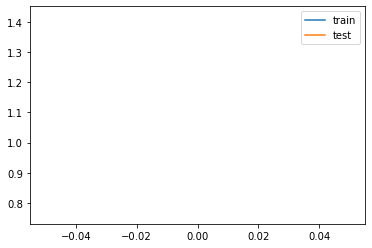

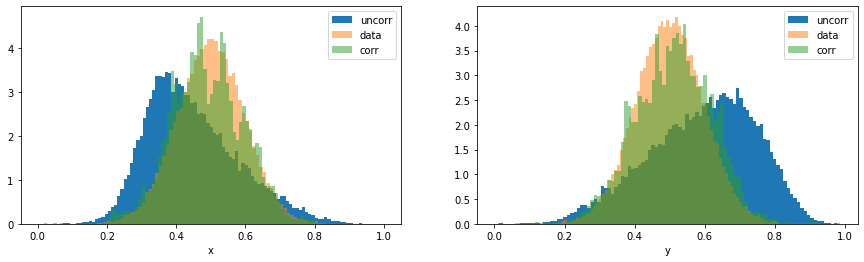

1
testing
2
testing
3
testing
4
testing


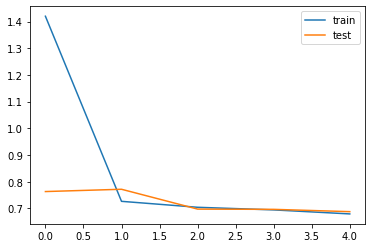

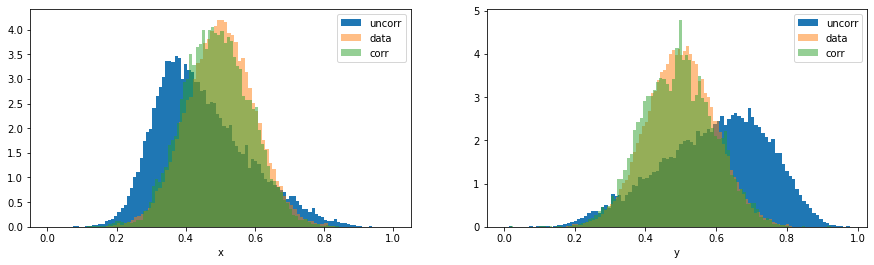

5
testing
6
testing
7
testing
8
testing


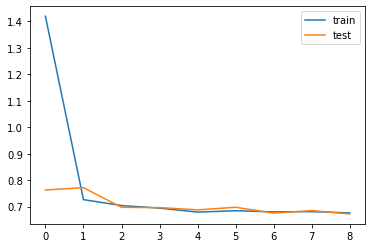

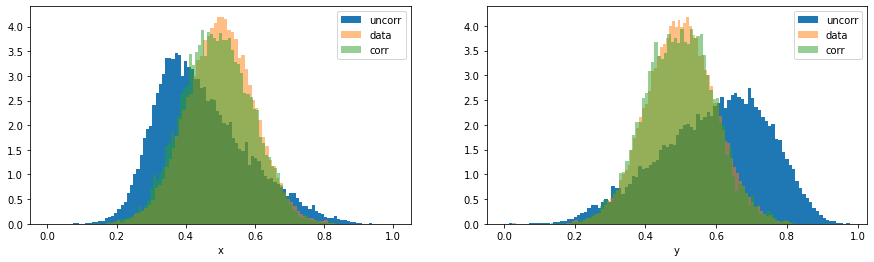

9
testing
10
testing
11
testing
12
testing


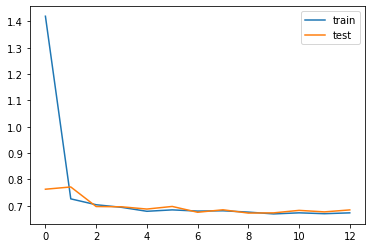

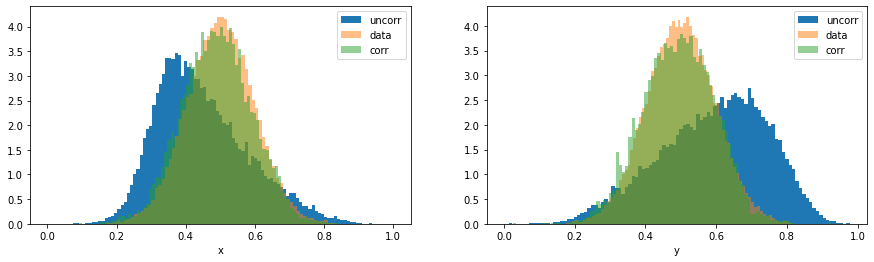

13
testing
14
testing
15
testing
16
testing


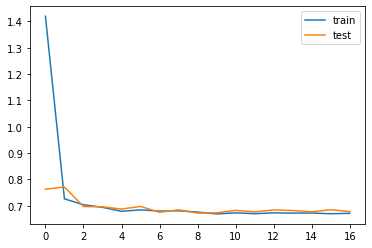

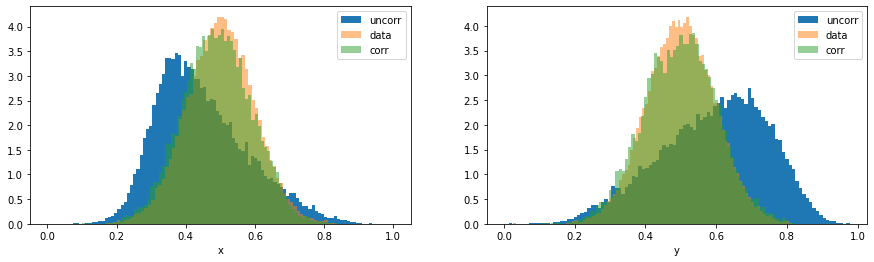

17
testing
18
testing
19
testing
20
testing


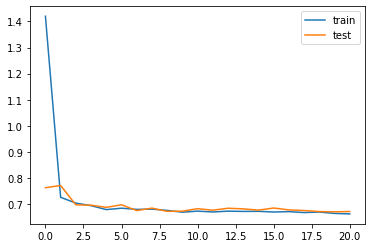

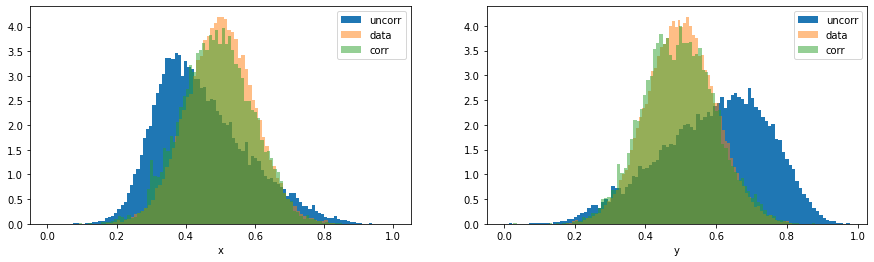

21
testing
22
testing
23
testing
24
testing


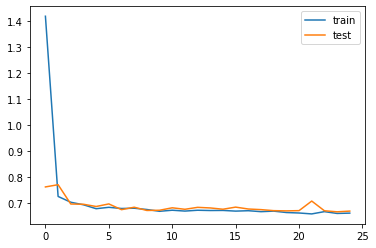

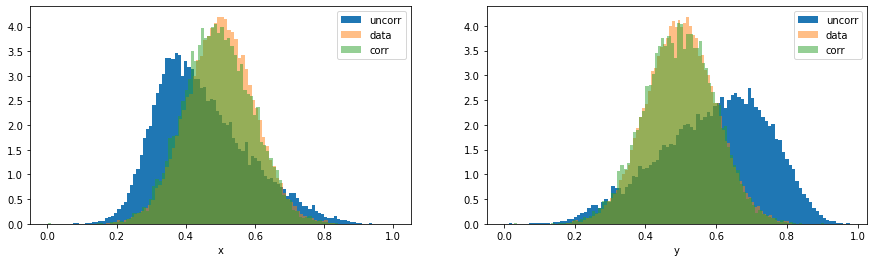

25
testing
26
testing
27
testing
28
testing


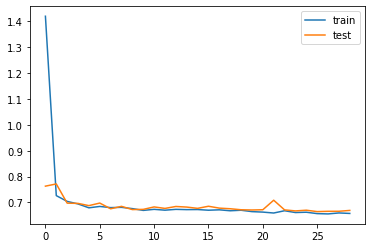

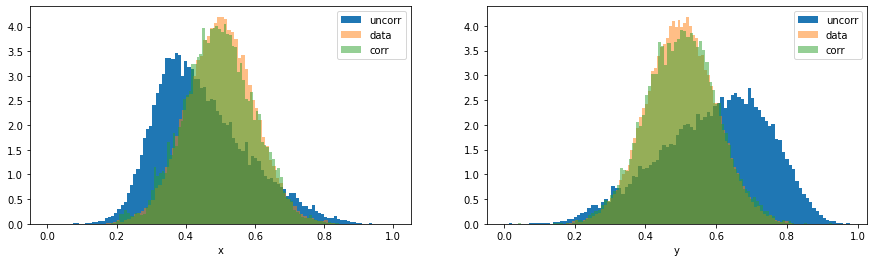

29
testing
30
testing
31
testing
32
testing


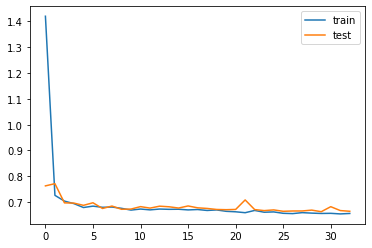

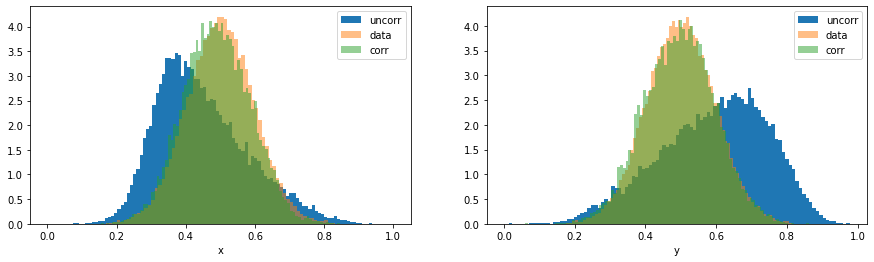

33
testing
34
testing
35
testing
36
testing


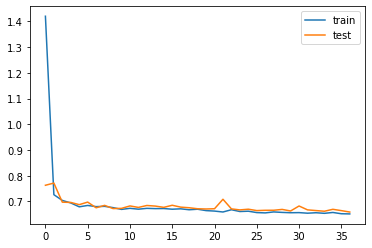

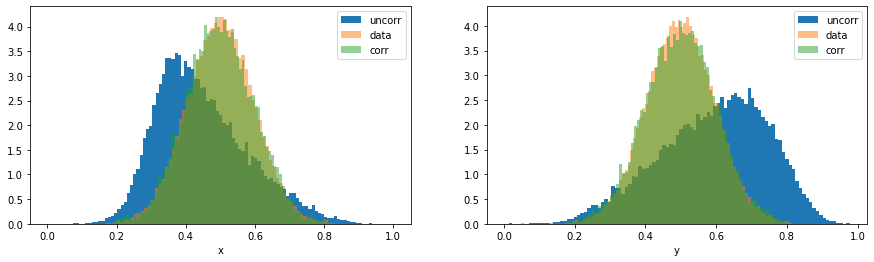

37
testing
38
testing
39
testing
40
testing


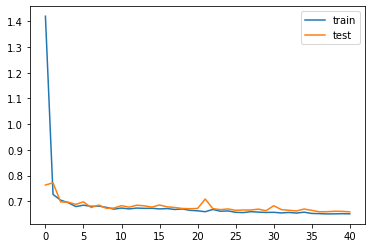

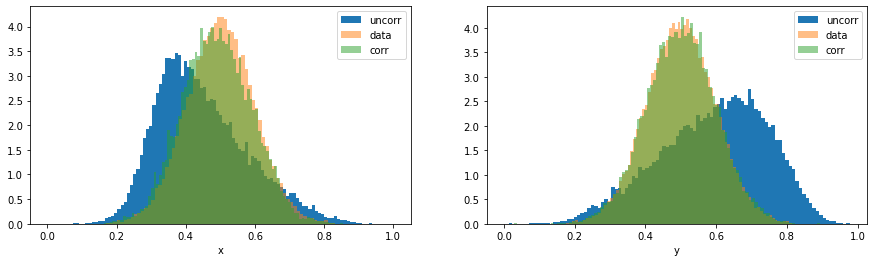

In [22]:
flow = make_flow_and_train(new_loader_train, new_loader_test, new_df_test, loader_test, loader_target_test)

## Apply it

In [ ]:
apply(flow, df_test, df_target_test)

In [18]:
transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform?

In [12]:
transforms.MaskedAffineAutoregressiveTransform?